In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [16]:
def print_hist_dencity(dist, plot_range, save_path):
    a = dict()
    a[10] = dist.rvs(10)
    a[50] = dist.rvs(50)
    a[1000] = dist.rvs(1000)
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    for num, ax in zip(a.keys(), axes):
        ax.set_title(f'Number of samples {num}')
        if isinstance(dist.dist, stats.rv_continuous):
            ax.hist(a[num], bins=np.sqrt(num).astype(int), range=plot_range, density=True, color='blue', alpha=0.5)
            x = np.linspace(plot_range[0], plot_range[1], num=int(1e5))
            ax.plot(x, dist.pdf(x), color='red')
        else:
            uniq, counts = np.unique(a[num], return_counts=True)
            ax.bar(uniq, counts/counts.sum(), color='blue', alpha=0.5)
            x = np.arange(plot_range[0], plot_range[1])
            ax.plot(x, dist.pmf(x))
    if save_path:
        plt.savefig(save_path)
    plt.show()

def q_mid(x):
    return np.percentile(x, [75, 25]).mean()

def statistics(dist):
    stats = np.empty((3, 6, 1000))
    for i in range(1000):
        a = dict().fromkeys(range(3))
        a[0] = dist.rvs(10)
        a[1] = dist.rvs(100)
        a[2] = dist.rvs(1000)
        for j in range(3):
            stats[j, :3, i] = np.array([a[j].mean(), np.median(a[j]), q_mid(a[j])])
            stats[j, 3:, i] = stats[j, :3, i] ** 2
    ans = stats.mean(axis=2)
    ans[:, 3:] = ans[:, 3:]-ans[:,:3]**2
    ans = pd.DataFrame(ans, columns=['Mean','Median','$z_Q$', 'Mean variance','Median variance','$z_Q$ variance'])
    ans = pd.concat((pd.DataFrame(np.array([10, 100, 1000]), columns=['Sample size']), ans), axis=1)
    return ans

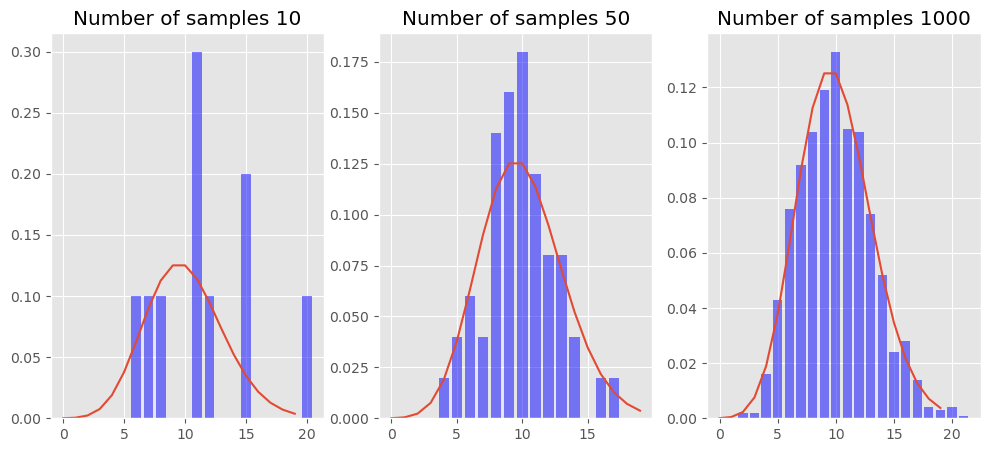

In [5]:
print_hist_dencity(stats.poisson(10), (0, 20), './poisson')

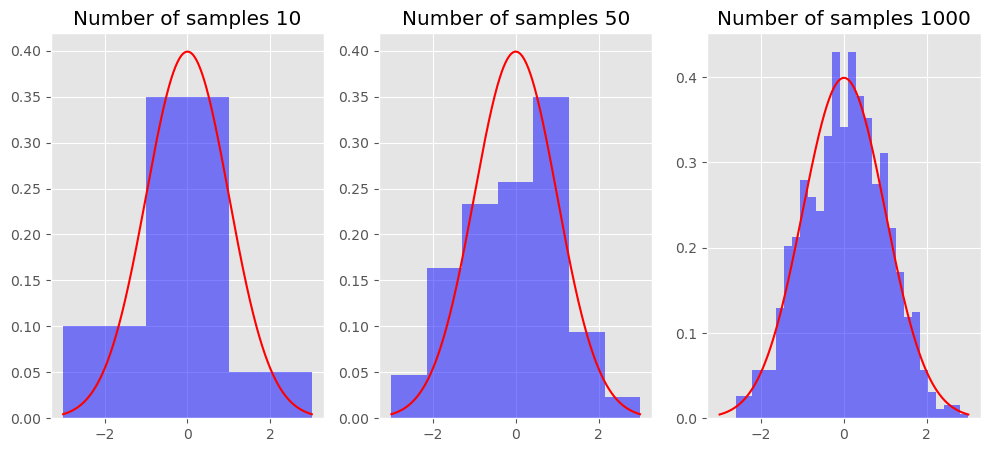

In [6]:
print_hist_dencity(stats.norm(0, 1), (-3, 3), './norm')

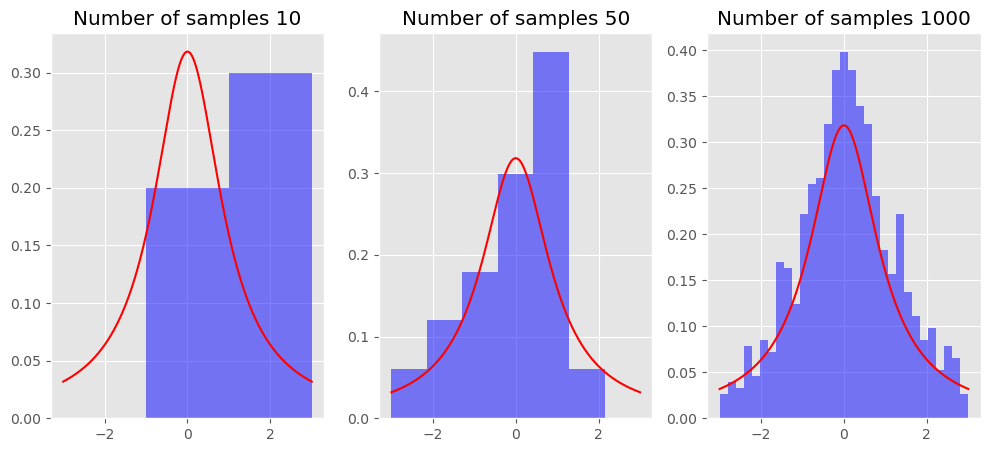

In [7]:
print_hist_dencity(stats.cauchy(0, 1), (-3, 3), './cauchy')

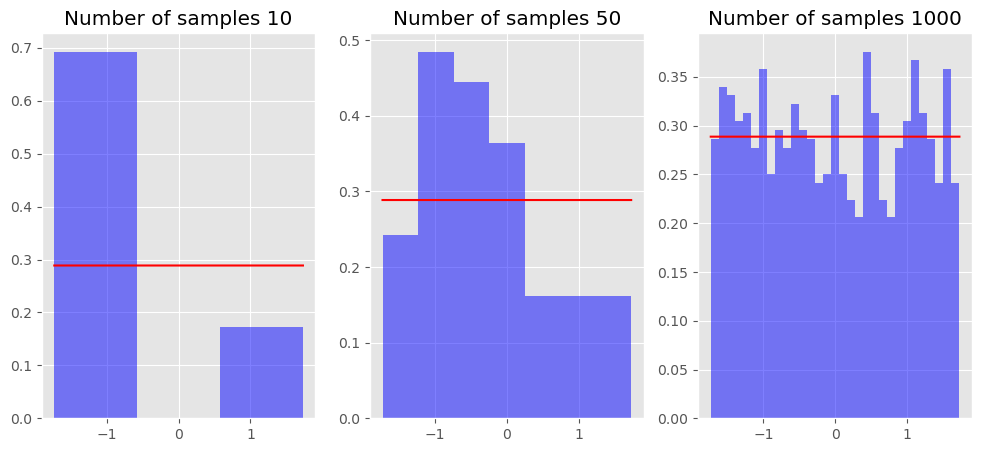

In [9]:
print_hist_dencity(stats.uniform(-np.sqrt(3), 2*np.sqrt(3)), (-np.sqrt(3), np.sqrt(3)), './uniform')

In [11]:
print(statistics(stats.poisson(10)).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & sample_size & Mean & Median & $z_Q$ & Mean variance & Median variance & $z_Q$ variance \\
\midrule
0 & 10 & 10.038800 & 9.888500 & 9.958500 & 1.009415 & 1.473318 & 1.148340 \\
1 & 100 & 10.014020 & 9.831000 & 9.931000 & 0.102530 & 0.205939 & 0.142583 \\
2 & 1000 & 9.996545 & 9.995000 & 9.996875 & 0.009288 & 0.004475 & 0.002006 \\
\bottomrule
\end{tabular}



In [14]:
print(statistics(stats.norm(0, 1)).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & sample_size & Mean & Median & $z_Q$ & Mean variance & Median variance & $z_Q$ variance \\
\midrule
0 & 10 & -0.007033 & -0.003508 & -0.011823 & 0.093453 & 0.134266 & 0.107423 \\
1 & 100 & 0.000043 & -0.000651 & 0.000761 & 0.010257 & 0.016686 & 0.012432 \\
2 & 1000 & -0.000211 & 0.000197 & -0.001179 & 0.000995 & 0.001542 & 0.001225 \\
\bottomrule
\end{tabular}



In [17]:
print(statistics(stats.cauchy(0, 1)).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & Sample size & Mean & Median & $z_Q$ & Mean variance & Median variance & $z_Q$ variance \\
\midrule
0 & 10 & 7.573363 & -0.035756 & -0.029379 & 37185.262821 & 0.315107 & 0.902379 \\
1 & 100 & -0.970891 & -0.001050 & -0.006343 & 11736.432538 & 0.025485 & 0.056413 \\
2 & 1000 & 0.620007 & -0.001454 & -0.001774 & 579.877803 & 0.002487 & 0.004768 \\
\bottomrule
\end{tabular}



In [18]:
print(statistics(stats.uniform(-np.sqrt(3), 2*np.sqrt(3))).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & Sample size & Mean & Median & $z_Q$ & Mean variance & Median variance & $z_Q$ variance \\
\midrule
0 & 10 & 0.008790 & 0.000124 & 0.010633 & 0.103650 & 0.240134 & 0.140943 \\
1 & 100 & 0.002832 & 0.007462 & 0.000386 & 0.009809 & 0.028952 & 0.014564 \\
2 & 1000 & -0.001059 & -0.001915 & -0.001206 & 0.001040 & 0.003340 & 0.001499 \\
\bottomrule
\end{tabular}

